# Match Report

## Importing Necessary Libraries

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import soccerdata as sd
from matplotlib.lines import Line2D
import soccerdata as sd
from matplotlib.colors import to_rgba

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "black"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

## Calling Understat with desired Match ID

In [108]:
#scrape a single game shots. We will allow users to enter a base url
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

Please enter the match id:  22221


## Function to scrape data from website as json

In [109]:
def scrape_understat(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content, "lxml")
    scripts = soup.find_all('script')
    
    string_with_json_obj = '' 
    # Find data for teams 
    for el in scripts: 
        if 'shotsData' in el.text: 
            string_with_json_obj = el.text.strip()
    #print(string_with_json_obj)
    
    # strip unnecessary symbols and get only JSON data 
    ind_start = string_with_json_obj.index("('")+2 
    ind_end = string_with_json_obj.index("')") 
    json_data = string_with_json_obj[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')
    
    #convert string to json format
    data = json.loads(json_data)
    return data


data = scrape_understat(url)

## Creating pandas df with scraped json

In [110]:
def create_df(data):
    x = []
    y = []
    xG = []
    result = []
    team = []
    player = []
    minute = []
    situation = []
    player_assisted = []
    data_away = data['a']
    data_home = data['h']
    
    for index in range(len(data_home)):
        for key in data_home[index]:
            if key == 'X':
                x.append(data_home[index][key])
            if key == 'Y':
                y.append(data_home[index][key])
            if key == 'h_team':
                team.append(data_home[index][key])
            if key == 'xG':
                xG.append(data_home[index][key])
            if key == 'result':
                result.append(data_home[index][key])
            if key == 'player':
                player.append(data_home[index][key])
            if key == 'minute':
                minute.append(data_home[index][key])
            if key == 'situation':
                situation.append(data_home[index][key])
            if key == 'player_assisted':
                player_assisted.append(data_home[index][key])
    
    for index in range(len(data_away)):
        for key in data_away[index]:
            if key == 'X':
                x.append(data_away[index][key])
            if key == 'Y':
                y.append(data_away[index][key])
            if key == 'a_team':
                team.append(data_away[index][key])
            if key == 'xG':
                xG.append(data_away[index][key])
            if key == 'result':
                result.append(data_away[index][key])
            if key == 'player':
                player.append(data_away[index][key])
            if key == 'minute':
                minute.append(data_away[index][key])
            if key == 'situation':
                situation.append(data_away[index][key])
            if key == 'player_assisted':
                player_assisted.append(data_away[index][key])

    col_names = ['x','y','xG','result','team','player','minute','situation','player_assisted']
    df = pd.DataFrame([x,y,xG,result,team,player,minute,situation,player_assisted],index=col_names)
    df = df.T
    df['x'] = pd.to_numeric(df['x'])
    df['y'] = pd.to_numeric(df['y'])
    df['xG'] = pd.to_numeric(df['xG'])
    df['minute'] = pd.to_numeric(df['minute'])
    
    df['x'] = df['x']*100
    df['y'] = df['y']*100
    
    df['xx'] = df['y']
    df['yy'] = df['x']
    
    df['x'] = df['xx']
    df['y'] = df['yy']
    
    df['x'] = df['x']*.8
    df['y'] = df['y']*1.2

    return df

df = create_df(data)

## Calculate Total xG Created by both Teams

In [111]:
hteam = df['team'].iloc[0]
ateam = df['team'].iloc[-1]
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

for x in range(len(df['xG'])):
    if df['team'][x] == ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['minute'][x])
    if df['team'][x] == hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['minute'][x])
    
def nums_cumulative_sum(nums_list):
  return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

acum = nums_cumulative_sum(a_xG)
hcum = nums_cumulative_sum(h_xG)
alast = round(acum[-1],2)
hlast = round(hcum[-1],2)

print(f"Total xG created by {ateam}: {alast}")
print(f"Total xG created by {hteam}: {hlast}")

Total xG created by Luton: 0.81
Total xG created by Manchester City: 4.75


## Calculate Total Shots and Total Shots On Target Taken by both Teams

In [112]:
def calculateTotalShotsByTeam(team):
    total_shots = 0
    total_shots_on_target = 0
    for x in range(len(df['x'])):
        if df['team'][x] == team:
            if df['result'][x] == 'SavedShot':
                total_shots += 1
                total_shots_on_target +=1
            else:
                total_shots += 1
    return total_shots,total_shots_on_target

# Example usage:
ateam_total_shots,ateam_total_shots_on_target = calculateTotalShotsByTeam(ateam)  # Replace 'ateam' with the desired team name
hteam_total_shots,hteam_total_shots_on_target = calculateTotalShotsByTeam(hteam)  # Replace 'hteam' with the desired team name

print(f"Total shots by {ateam}: {ateam_total_shots}")
print(f"Total shots on target by {ateam}: {ateam_total_shots_on_target}")
print(f"Total shots by {hteam}: {hteam_total_shots}")
print(f"Total shots on target by {hteam}: {hteam_total_shots_on_target}")

Total shots by Luton: 5
Total shots on target by Luton: 1
Total shots by Manchester City: 37
Total shots on target by Manchester City: 9


## Calculating Goals Scored by each team

In [115]:
df['result'].unique()

array(['SavedShot', 'BlockedShot', 'MissedShots', 'ShotOnPost', 'Goal',
       'OwnGoal'], dtype=object)

In [116]:
def calculateTotalGoalsByTeam(hteam,ateam):
    total_goals_hteam = 0
    total_goals_ateam = 0
    for x in range(len(df['x'])):
        if df['team'][x] == hteam:
            if df['result'][x] == 'Goal':
                total_goals_hteam += 1
            if df['result'][x] == 'OwnGoal':  
                total_goals_ateam +=1
        if df['team'][x] == ateam:
            if df['result'][x] == 'Goal':
                total_goals_ateam += 1
            if df['result'][x] == 'OwnGoal':  
                total_goals_hteam +=1
    return total_goals_hteam,total_goals_ateam


hteam_total_goals , ateam_total_goals = calculateTotalGoalsByTeam(hteam,ateam)  # Replace 'hteam' with the desired team name

print(f"Total goals by {ateam}: {ateam_total_goals}")
print(f"Total goals by {hteam}: {hteam_total_goals}")

Total goals by Luton: 1
Total goals by Manchester City: 5


## Using Soccerdata lib to extract Stats from FotMoob

In [70]:
hteam = 'Manchester City'
ateam = 'Luton Town'
fotmob = sd.FotMob(leagues='ENG-Premier League', seasons='2023/2024')
match_stats_hteam = fotmob.read_team_match_stats(opponent_stats=False, team=hteam,stat_type='Top stats')
match_stats_ateam = fotmob.read_team_match_stats(opponent_stats=False, team=ateam,stat_type='Top stats')

[04/14/24 12:07:46] INFO     Saving cached data to C:\Users\acer\soccerdata\data\FotMob               ]8;id=491721;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=620286;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py#91\91]8;;\

[04/14/24 12:07:49] INFO     [1/32] Retrieving game with id=4193450                                   ]8;id=654335;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=463630;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [2/32] Retrieving game with id=4193475                                   ]8;id=72679;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=523018;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [3/32] Retrieving game with id=4193489                                   ]8;id=729721;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=75508;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [4/32] Retrieving game with id=4193498                                   ]8;id=649586;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=505840;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [5/32] Retrieving game with id=4193508                                   ]8;id=122664;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=833896;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [6/32] Retrieving game with id=4193518                                   ]8;id=988181;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=161177;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:07:50] INFO     [7/32] Retrieving game with id=4193529                                   ]8;id=88327;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=475314;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [8/32] Retrieving game with id=4193530                                   ]8;id=1935;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=856175;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [9/32] Retrieving game with id=4193545                                   ]8;id=259627;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=799454;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [10/32] Retrieving game with id=4193557                                  ]8;id=409342;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=886849;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [11/32] Retrieving game with id=4193565                                  ]8;id=314610;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=828643;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [12/32] Retrieving game with id=4193574                                  ]8;id=522090;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=917614;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [13/32] Retrieving game with id=4193656                                  ]8;id=394338;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=868771;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [14/32] Retrieving game with id=4193667                                  ]8;id=494460;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=669647;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [15/32] Retrieving game with id=4193671                                  ]8;id=583172;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=61176;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [16/32] Retrieving game with id=4193686                                  ]8;id=445578;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=33672;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [17/32] Retrieving game with id=4193697                                  ]8;id=226032;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=157177;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [18/32] Retrieving game with id=4193717                                  ]8;id=17402;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=311394;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:07:51] INFO     [19/32] Retrieving game with id=4193726                                  ]8;id=646765;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=777982;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [20/32] Retrieving game with id=4193739                                  ]8;id=677452;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=38113;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [21/32] Retrieving game with id=4193750                                  ]8;id=334144;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=345087;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [22/32] Retrieving game with id=4193753                                  ]8;id=855406;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=860397;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:07:55] INFO     [23/32] Retrieving game with id=4193766                                  ]8;id=563900;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=108492;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [24/32] Retrieving game with id=4193776                                  ]8;id=915669;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=475626;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [25/32] Retrieving game with id=4193706                                  ]8;id=953552;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=52431;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [26/32] Retrieving game with id=4193781                                  ]8;id=866844;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=202976;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:07:56] INFO     [27/32] Retrieving game with id=4193796                                  ]8;id=763121;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=354248;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [28/32] Retrieving game with id=4193807                                  ]8;id=890482;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=956662;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [29/32] Retrieving game with id=4193826                                  ]8;id=696915;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=975967;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [30/32] Retrieving game with id=4193840                                  ]8;id=253892;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=132364;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [31/32] Retrieving game with id=4193843                                  ]8;id=493269;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=24660;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [32/32] Retrieving game with id=4193857                                  ]8;id=408089;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=986600;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:07:58] INFO     [1/33] Retrieving game with id=4193453                                   ]8;id=582292;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=60460;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:00] INFO     [2/33] Retrieving game with id=4193485                                   ]8;id=571148;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=446586;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:01] INFO     [3/33] Retrieving game with id=4193497                                   ]8;id=682157;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=744347;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:02] INFO     [4/33] Retrieving game with id=4193503                                   ]8;id=104896;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=229197;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:03] INFO     [5/33] Retrieving game with id=4193517                                   ]8;id=663107;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=396556;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:04] INFO     [6/33] Retrieving game with id=4193522                                   ]8;id=654777;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=917126;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:06] INFO     [7/33] Retrieving game with id=4193474                                   ]8;id=314213;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=920647;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:08] INFO     [8/33] Retrieving game with id=4193536                                   ]8;id=580135;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=315467;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:11] INFO     [9/33] Retrieving game with id=4193547                                   ]8;id=950347;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=530304;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:12] INFO     [10/33] Retrieving game with id=4193552                                  ]8;id=298454;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=741272;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:14] INFO     [11/33] Retrieving game with id=4193564                                  ]8;id=508360;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=627832;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:17] INFO     [12/33] Retrieving game with id=4193577                                  ]8;id=445976;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=519911;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [13/33] Retrieving game with id=4193655                                  ]8;id=21832;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=391720;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:18] INFO     [14/33] Retrieving game with id=4193663                                  ]8;id=264473;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=383659;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [15/33] Retrieving game with id=4193675                                  ]8;id=818962;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=899430;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [16/33] Retrieving game with id=4193686                                  ]8;id=439336;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=12636;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:21] INFO     [17/33] Retrieving game with id=4193705                                  ]8;id=355182;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=114252;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:22] INFO     [18/33] Retrieving game with id=4193720                                  ]8;id=992167;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=479007;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:24] INFO     [19/33] Retrieving game with id=4193725                                  ]8;id=32268;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=857466;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:25] INFO     [20/33] Retrieving game with id=4193735                                  ]8;id=944290;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=139997;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [21/33] Retrieving game with id=4193743                                  ]8;id=152504;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=65204;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:29] INFO     [22/33] Retrieving game with id=4193759                                  ]8;id=454268;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=935203;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:31] INFO     [23/33] Retrieving game with id=4193765                                  ]8;id=642383;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=131047;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:34] INFO     [24/33] Retrieving game with id=4193775                                  ]8;id=793135;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=496512;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:35] INFO     [25/33] Retrieving game with id=4193787                                  ]8;id=841461;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=238442;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [26/33] Retrieving game with id=4193795                                  ]8;id=730994;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=158331;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [27/33] Retrieving game with id=4193806                                  ]8;id=595307;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=883429;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:37] INFO     [28/33] Retrieving game with id=4421797                                  ]8;id=909850;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=762147;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:39] INFO     [29/33] Retrieving game with id=4193817                                  ]8;id=41409;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=631354;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:41] INFO     [30/33] Retrieving game with id=4193830                                  ]8;id=425688;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=988785;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:42] INFO     [31/33] Retrieving game with id=4193832                                  ]8;id=198394;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=421802;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[04/14/24 12:08:43] INFO     [32/33] Retrieving game with id=4193846                                  ]8;id=299670;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=809294;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [33/33] Retrieving game with id=4193857                                  ]8;id=548331;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=624440;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

In [118]:
#### Stats extracted from FotMob dataframes - done manually as of now, need to find a better method

possesion_hteam = 74
possesion_ateam = 26
big_chances_ateam = 2
big_chances_hteam = 5
accurate_passes_per_hteam = 92
accurate_passes_per_ateam = 78

## Creating Plot for Overall Stats

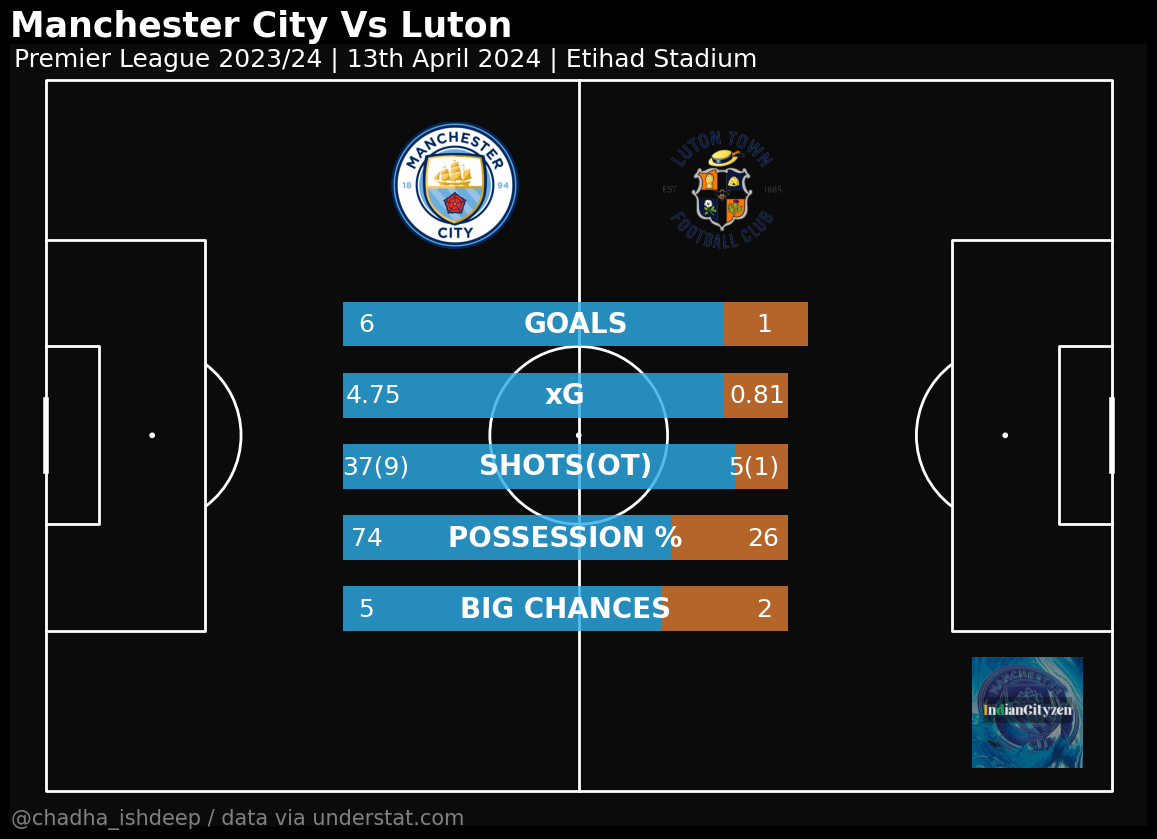

In [119]:
pitch = Pitch(pitch_color='black', line_color='white',
              stripe=False)  # optional stripes
fig, ax = pitch.draw(figsize=(13,8.5))
fig.set_facecolor('black')
ax.patch.set_facecolor('#0B0B0B')

img_hteam = mpimg.imread('Images/TeamLogos/ManchesterCity.png')
img_ateam = mpimg.imread('Images/TeamLogos/Luton.png')
logo = mpimg.imread('Images/IndianCityzen.png')


ax_image = add_image(
    img_hteam, fig, left=0.33, bottom=0.7, width=0.15, height=0.15,aspect='equal'
)

ax_image = add_image(
    img_ateam, fig, left=0.52, bottom=0.68, width=0.18, height=0.18,aspect='equal'
)

ax_image = add_image(
    logo, fig, left=0.78, bottom=0.09, width=0.13, height=0.13,alpha=0.9,aspect='equal'
)


# Set title
ax.set_title(f'{hteam} Vs {ateam}',fontdict={'fontsize': 25, 'weight': 'bold', 'color': 'white'}, loc='left')
# Add subtitle
subtitle_text = "Premier League 2023/24 | 13th April 2024 | Etihad Stadium"
ax.text(0.33, 0.98, subtitle_text, ha='center', va='center', transform=ax.transAxes, color='white', fontsize=18)

##### Adding Goals

goals_hteam = hteam_total_goals+1
goals_ateam = ateam_total_goals

# Calculate the width of the rectangle for each team
total_goals = goals_hteam + goals_ateam

# Define the minimum width for the rectangles
min_rect_width = 9.5

#width_hteam = goals_hteam / total_goals
#width_ateam = goals_ateam / total_goals

# Coordinates for the rectangle
rect_x = 33.5 # X-coordinate of the left side of the rectangle
rect_y = 25  # Y-coordinate of the top side of the rectangle
rect_width = 50  # Width of the rectangle
rect_height = 5  # Height of the rectangle

# Calculate the width of the rectangle for each team
if total_goals > 0:
    width_hteam = max(goals_hteam / total_goals, min_rect_width / rect_width)
    width_ateam = max(goals_ateam / total_goals, min_rect_width / rect_width)
else:
    # Both teams scored 0 goals, set equal width for both
    width_hteam = min_rect_width / rect_width
    width_ateam = min_rect_width / rect_width

hteam_facecolor = '#2CAEEA'
ateam_facecolor = '#E17B32'

# Create a rectangle patch for hteam
rect_hteam = Rectangle((rect_x, rect_y), width_hteam * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
rect_ateam = Rectangle((rect_x + width_hteam * rect_width, rect_y), width_ateam * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(rect_hteam)
ax.add_patch(rect_ateam)

# Calculate the position for 'GOALS' text
goals_text_x = rect_x + width_hteam * rect_width + (width_ateam * rect_width - width_hteam * rect_width) / 2
goals_text_y = rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(37, rect_y + rect_height / 2, str(goals_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(goals_text_x, goals_text_y, 'GOALS', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(80, rect_y + rect_height / 2, str(goals_ateam), color='white', ha='left', va='center',fontsize=18)



#### Adding xG
xG_hteam = hlast
xG_ateam = alast

# Calculate the width of the rectangle for each team
total_xG = xG_hteam + xG_ateam
width_hteam_xG = xG_hteam / total_xG
width_ateam_xG = xG_ateam / total_xG

# Coordinates for the rectangle
xG_rect_x = 33.5 # X-coordinate of the left side of the rectangle
xG_rect_y = 33 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
xG_rect_hteam = Rectangle((xG_rect_x, xG_rect_y), width_hteam_xG * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
xG_rect_ateam = Rectangle((xG_rect_x + width_hteam_xG * rect_width, xG_rect_y), width_ateam_xG * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(xG_rect_hteam)
ax.add_patch(xG_rect_ateam)

# Calculate the position for 'GOALS' text
xG_text_x = xG_rect_x + width_hteam_xG * rect_width + (width_ateam_xG * rect_width - width_hteam_xG * rect_width) / 2
xG_text_y = xG_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(40, xG_rect_y + rect_height / 2, str(xG_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(xG_text_x, xG_text_y, 'xG', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(77, xG_rect_y + rect_height / 2, str(xG_ateam), color='white', ha='left', va='center',fontsize=18)

#### Adding Shots
shots_hteam = hteam_total_shots
shots_ateam = ateam_total_shots

shots_hteam_ot = hteam_total_shots_on_target
shots_ateam_ot = ateam_total_shots_on_target

# Calculate the width of the rectangle for each team
total_shots = shots_hteam + shots_ateam
width_hteam_shots = shots_hteam / total_shots
width_ateam_shots = shots_ateam / total_shots

# Coordinates for the rectangle
shots_rect_x = 33.5 # X-coordinate of the left side of the rectangle
shots_rect_y = 41 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
shots_rect_hteam = Rectangle((shots_rect_x, shots_rect_y), width_hteam_shots * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
shots_rect_ateam = Rectangle((shots_rect_x + width_hteam_shots * rect_width, shots_rect_y), width_ateam_shots * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(shots_rect_hteam)
ax.add_patch(shots_rect_ateam)

# Calculate the position for 'GOALS' text
shots_text_x = shots_rect_x + width_hteam_shots * rect_width + (width_ateam_shots * rect_width - width_hteam_shots * rect_width) / 2
shots_text_y = shots_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(40.9, shots_rect_y + rect_height / 2, str(shots_hteam) + '(' + str(shots_hteam_ot) + ')', color='white', ha='right', va='center',fontsize=18)
ax.text(shots_text_x, shots_text_y, 'SHOTS(OT)', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(76.8, shots_rect_y + rect_height / 2, str(shots_ateam) + '(' + str(shots_ateam_ot) + ')', color='white', ha='left', va='center',fontsize=18)

#### Adding possesion
# Calculate the width of the rectangle for each team
total_possesion = possesion_hteam + possesion_ateam
width_hteam_possesion = possesion_hteam / total_possesion
width_ateam_possesion = possesion_ateam / total_possesion

# Coordinates for the rectangle
possesion_rect_x = 33.5 # X-coordinate of the left side of the rectangle
possesion_rect_y = 49 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
possesion_rect_hteam = Rectangle((possesion_rect_x, possesion_rect_y), width_hteam_possesion * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
possesion_rect_ateam = Rectangle((possesion_rect_x + width_hteam_possesion * rect_width, possesion_rect_y), width_ateam_possesion * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(possesion_rect_hteam)
ax.add_patch(possesion_rect_ateam)

# Calculate the position for 'GOALS' text
possesion_text_x = possesion_rect_x + width_hteam_possesion * rect_width + (width_ateam_possesion * rect_width - width_hteam_possesion * rect_width) / 2
possesion_text_y = possesion_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(38, possesion_rect_y + rect_height / 2, str(possesion_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(possesion_text_x, possesion_text_y, 'POSSESSION %', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(79, possesion_rect_y + rect_height / 2, str(possesion_ateam), color='white', ha='left', va='center',fontsize=18)

### Adding big_chances
# Calculate the width of the rectangle for each team
total_big_chances = big_chances_hteam + big_chances_ateam
width_hteam_big_chances = big_chances_hteam / total_big_chances
width_ateam_big_chances = big_chances_ateam / total_big_chances

# Coordinates for the rectangle
big_chances_rect_x = 33.5 # X-coordinate of the left side of the rectangle
big_chances_rect_y = 57 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
big_chances_rect_hteam = Rectangle((big_chances_rect_x, big_chances_rect_y), width_hteam_big_chances * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
big_chances_rect_ateam = Rectangle((big_chances_rect_x + width_hteam_big_chances * rect_width, big_chances_rect_y), width_ateam_big_chances * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(big_chances_rect_hteam)
ax.add_patch(big_chances_rect_ateam)

# Calculate the position for 'GOALS' text
big_chances_text_x = big_chances_rect_x + width_hteam_big_chances * rect_width + (width_ateam_big_chances * rect_width - width_hteam_big_chances * rect_width) / 2
big_chances_text_y = big_chances_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(37, big_chances_rect_y + rect_height / 2, str(big_chances_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(big_chances_text_x, big_chances_text_y, 'BIG CHANCES', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(80, big_chances_rect_y + rect_height / 2, str(big_chances_ateam), color='white', ha='left', va='center',fontsize=18)


endnote_text = "@chadha_ishdeep / data via understat and fotmob.com"
ax.annotate(endnote_text, xy=(0.2, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=15, color='gray')

plt.savefig('MatchReports/CityHome/13-04-2024/CityVLuton.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Function for Shot Map

In [96]:
def plotShotMap(team,goal_color,annotate=False):
    for x in range(len(df['x'])):
        if df['team'][x] == team:
            if df['result'][x] == 'Goal':
                if df['xG'][x] > 0.5:
                    plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*1000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                    if annotate:
                        ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=10, color=goal_color)
                else:
                    plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*5000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                    if annotate:
                        ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=10, color=goal_color)
            elif df['result'][x] == 'SavedShot': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*300, edgecolor='white', linewidth=2, alpha=0.9,marker='x')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=12, color=goal_color)
            else:
                plt.scatter(df['x'][x], df['y'][x], color='#F4F7F8', s=df['xG'][x]*500, edgecolor='white', alpha=0.9)

## Function for Goal Map

In [91]:
def plotGoalMap(team,goal_color,annotate=False):
    for x in range(len(df['x'])):
        if df['team'][x] == team:
            if df['result'][x] == 'Goal': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*10000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=13, color='#2CAEEA')
            else:
                plt.scatter(df['x'][x], df['y'][x], color='#F4F7F8', s=df['xG'][x]*500, edgecolor='white', alpha=0.9)

## Function for ShotMap by Specific Player

In [92]:
def plotShotMap_player(team,goal_color,player,annotate=False):
    for x in range(len(df['x'])):
        if df['team'][x] == team and df['player'][x] == player:
            if df['result'][x] == 'Goal': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*10000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, f"xG = {df['xG'][x]:.2f}", fontsize=14, color=goal_color)
            elif df['result'][x] == 'SavedShot': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*300, edgecolor='white', linewidth=2, alpha=0.9,marker='x')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, f"xG = {df['xG'][x]:.2f}", fontsize=12, color=goal_color)
            else:
                plt.scatter(df['x'][x], df['y'][x], color='#F4F7F8', s=df['xG'][x]*500, edgecolor='white', alpha=0.9)

## Creating Plots for shots and goals

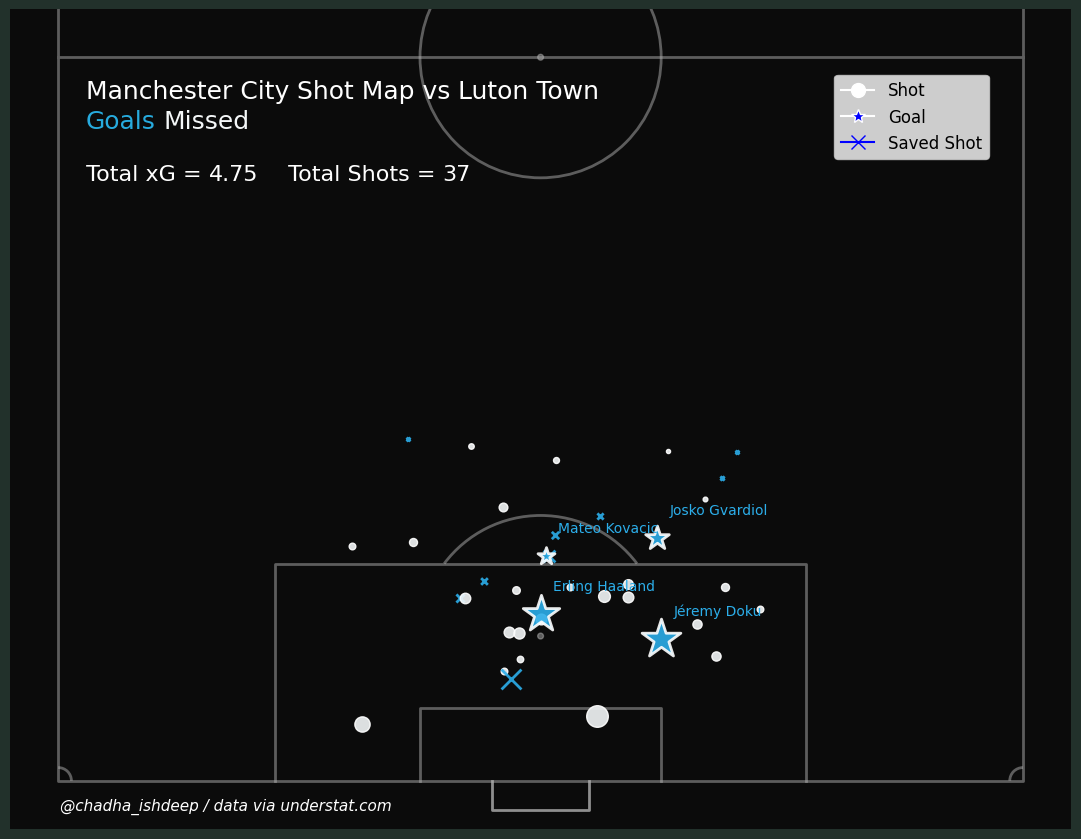

In [93]:
pitch = VerticalPitch(pitch_type='statsbomb',half=True,
                 line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')

fig, ax = pitch.draw(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#0B0B0B')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

#plt.ylim(0,60)

plotShotMap(hteam,'#2CAEEA',annotate=True)

s1 = '<{}> Shot Map vs <{}> \n<Goals> <Missed>'
highlight_text.fig_text(
                x=.15,y=.9,
                s = s1.format(hteam,ateam),
                #highlight_weights=['bold'],
                #string_weight='bold',
                fontsize=18,
                #fontname='Roboto',
                color=text_color,
                #highlight_colors=['#74c69d','#ff4d4d'],
                highlight_textprops=[{"color" : 'white'},{"color" : 'white'},{"color": '#27ABDE'},{"color": '#F4F7F8'}],
                ax = ax)

s2 = ' Total xG = <{}>'
highlight_text.fig_text(
               x=.145,y=.8,
               s = s2.format(hlast),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

s3 = ' Total Shots = <{}>'
highlight_text.fig_text(
               x=.3,y=.8,
               s = s3.format(hteam_total_shots),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

fig.text(.13,.04,"@chadha_ishdeep / data via understat.com",fontstyle='italic',fontsize=11,color=text_color)
# Define custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, label='Shot'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=10, label='Goal'),
    Line2D([0], [0], marker='x', color='b', markerfacecolor='blue', markersize=10, label='Saved Shot')
]

# Add legend
ax.legend(handles=legend_elements,  bbox_to_anchor=(0.93, 0.93), fontsize=12)

plt.savefig('MatchReports/CityHome/13-04-2024/Cityshotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)

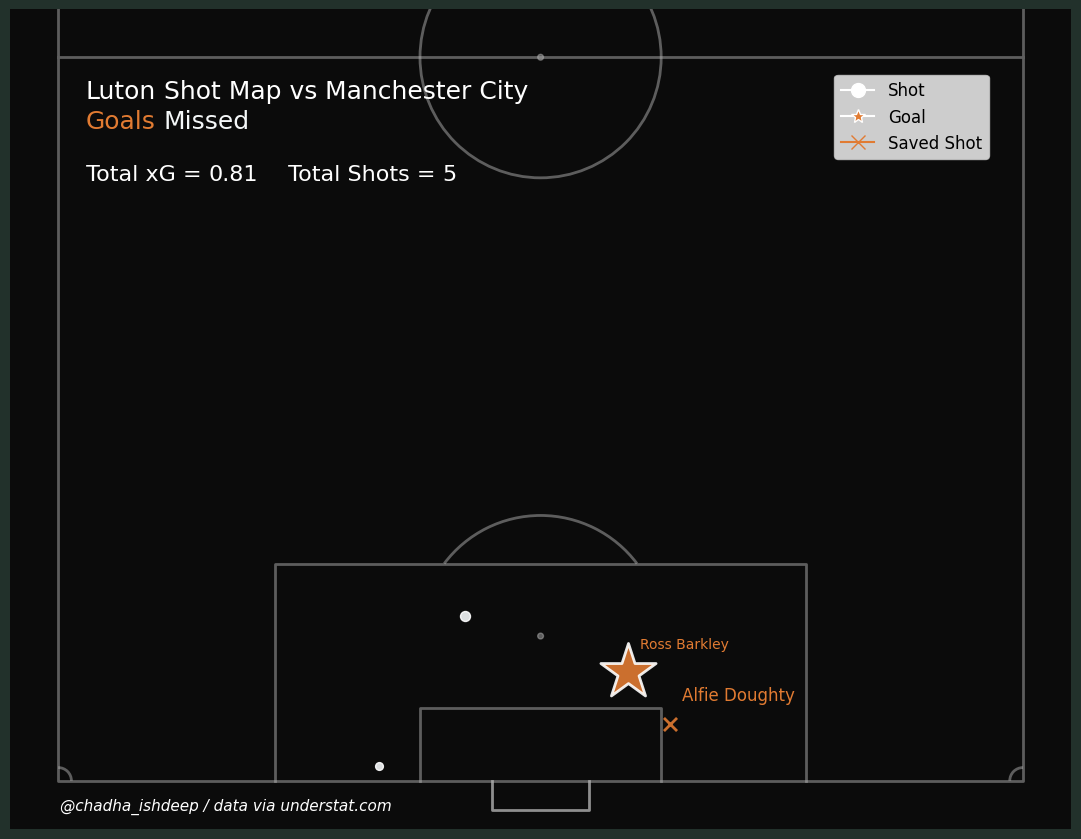

In [100]:
pitch = VerticalPitch(pitch_type='statsbomb',half=True,
                 line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')

fig, ax = pitch.draw(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#0B0B0B')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

#plt.ylim(0,60)
ateam = 'Luton'
plotShotMap(ateam,'#E17B32',annotate=True)

s1 = '<{}> Shot Map vs <{}> \n<Goals> <Missed>'
highlight_text.fig_text(
                x=.15,y=.9,
                s = s1.format(ateam,hteam),
                #highlight_weights=['bold'],
                #string_weight='bold',
                fontsize=18,
                #fontname='Roboto',
                color=text_color,
                #highlight_colors=['#74c69d','#ff4d4d'],
                highlight_textprops=[{"color" : 'white'},{"color" : 'white'},{"color": '#E17B32'},{"color": '#F4F7F8'}],
                ax = ax)

s2 = ' Total xG = <{}>'
highlight_text.fig_text(
               x=.145,y=.8,
               s = s2.format(alast),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

s3 = ' Total Shots = <{}>'
highlight_text.fig_text(
               x=.3,y=.8,
               s = s3.format(ateam_total_shots),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

fig.text(.13,.04,"@chadha_ishdeep / data via understat.com",fontstyle='italic',fontsize=11,color=text_color)


# Define custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, label='Shot'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='#E17B32', markersize=10, label='Goal'),
    Line2D([0], [0], marker='x', color='#E17B32', markerfacecolor='#E17B32', markersize=10, label='Saved Shot')
]

# Add legend
ax.legend(handles=legend_elements,  bbox_to_anchor=(0.93, 0.93), fontsize=12)

plt.savefig('MatchReports/CityHome/13-04-2024/Lutonshotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)

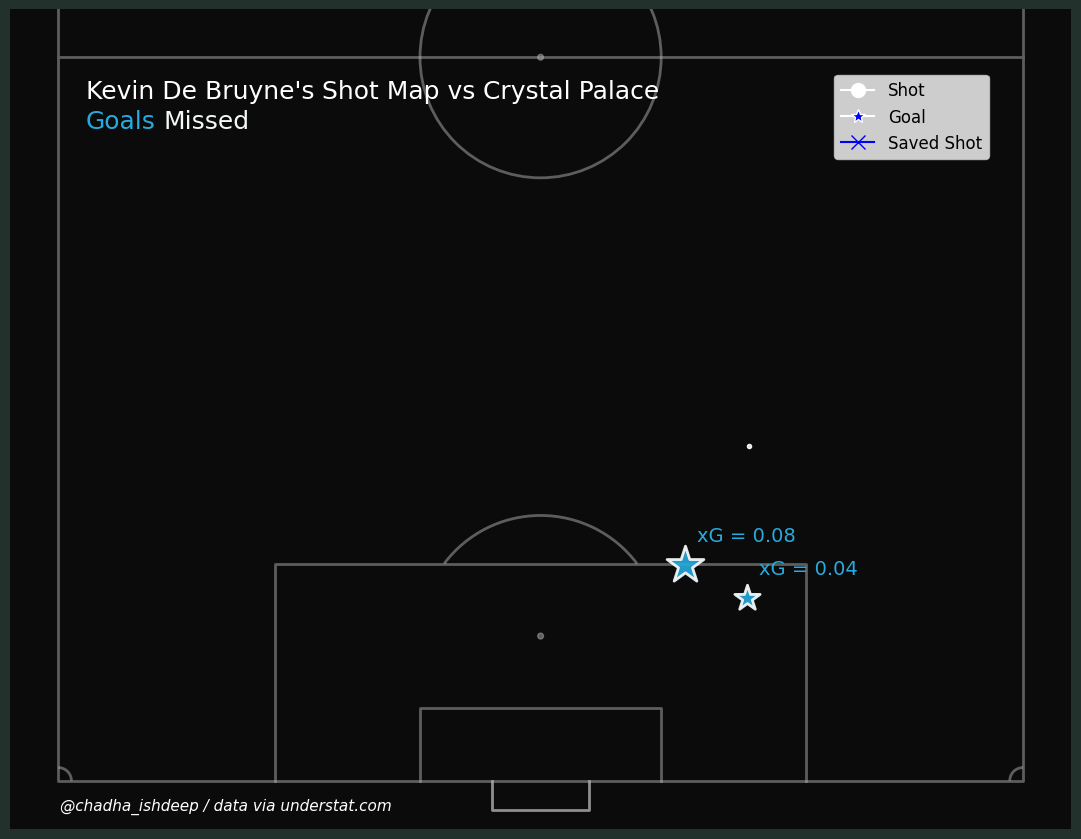

In [61]:
pitch = VerticalPitch(pitch_type='statsbomb',half=True,
                 line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')

fig, ax = pitch.draw(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#0B0B0B')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

#plt.ylim(0,60)
player = "Kevin De Bruyne's"
plotShotMap_player(ateam,'#27ABDE','Kevin De Bruyne',annotate=True)

s1 = '<{}> Shot Map vs <{}> \n<Goals> <Missed>'
highlight_text.fig_text(
                x=.15,y=.9,
                s = s1.format(player,hteam),
                #highlight_weights=['bold'],
                #string_weight='bold',
                fontsize=18,
                #fontname='Roboto',
                color=text_color,
                #highlight_colors=['#74c69d','#ff4d4d'],
                highlight_textprops=[{"color" : 'white'},{"color" : 'white'},{"color": '#27ABDE'},{"color": '#F4F7F8'}],
                ax = ax)

fig.text(.13,.04,"@chadha_ishdeep / data via understat.com",fontstyle='italic',fontsize=11,color=text_color)
# Define custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, label='Shot'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=10, label='Goal'),
    Line2D([0], [0], marker='x', color='b', markerfacecolor='blue', markersize=10, label='Saved Shot')
]

# Add legend
ax.legend(handles=legend_elements,  bbox_to_anchor=(0.93, 0.93), fontsize=12)

plt.savefig('MatchReports/CityAway/06-04-2024/KevinshotmapPalace.png',dpi=300,bbox_inches = 'tight',facecolor=background)

## Using Soccerdata lib to extract data from WhoScored.com

In [130]:
ws = sd.WhoScored(leagues="ENG-Premier League", seasons="2023/2024")
#print(ws.__doc__)

[04/20/24 16:14:15] INFO     Saving cached data to C:\Users\acer\soccerdata\data\WhoScored            ]8;id=184625;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=612240;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py#91\91]8;;\

In [131]:
match_id = 1729407
df_whoscored = ws.read_events(match_id=1729407)

[04/20/24 16:14:45] INFO     Scraping game schedule from                                           ]8;id=215075;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=872528;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#428\428]8;;\
                             https://www.whoscored.com/Regions/252/Tournaments/2/Seasons/9618/Engl                 
                             and-Premier-League                                                                    

                    INFO     Scraping game schedule for Jumanne, Apr 2 2024                        ]8;id=682121;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=192915;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:46] INFO     Scraping game schedule for Jumatano, Apr 3 2024                       ]8;id=102168;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=78859;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:47] INFO     Scraping game schedule for Alhamisi, Apr 4 2024                       ]8;id=430470;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=647269;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Apr 6 2024                       ]8;id=544872;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=441862;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:48] INFO     Scraping game schedule for Jumapili, Apr 7 2024                       ]8;id=885287;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=981506;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:49] INFO     Scraping game schedule for Jumamosi, Apr 13 2024                      ]8;id=844860;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=984077;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:50] INFO     Scraping game schedule for Jumapili, Apr 14 2024                      ]8;id=921835;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=428576;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Apr 15 2024                      ]8;id=269780;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=352710;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:51] INFO     Scraping game schedule for Jumamosi, Apr 20 2024                      ]8;id=662207;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=726979;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Apr 21 2024                      ]8;id=185755;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=421135;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:52] INFO     Scraping game schedule for Jumanne, Apr 23 2024                       ]8;id=807393;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=696088;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatano, Apr 24 2024                      ]8;id=445157;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=496384;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:53] INFO     Scraping game schedule for Alhamisi, Apr 25 2024                      ]8;id=961162;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=97315;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Apr 27 2024                      ]8;id=240052;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=24747;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:14:54] INFO     Scraping game schedule for Jumapili, Apr 28 2024                      ]8;id=846559;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=96874;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:00] INFO     Scraping game schedule for Jumamosi, Mac 2 2024                       ]8;id=537509;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=896510;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:01] INFO     Scraping game schedule for Jumapili, Mac 3 2024                       ]8;id=175715;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=498233;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Mac 4 2024                       ]8;id=941553;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=747531;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Mac 9 2024                       ]8;id=101961;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=670967;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:02] INFO     Scraping game schedule for Jumapili, Mac 10 2024                      ]8;id=410234;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=759523;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:03] INFO     Scraping game schedule for Jumatatu, Mac 11 2024                      ]8;id=277616;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=761716;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatano, Mac 13 2024                      ]8;id=941146;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=904327;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Mac 16 2024                      ]8;id=789846;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=931228;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:04] INFO     Scraping game schedule for Jumapili, Mac 17 2024                      ]8;id=201739;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=718164;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Mac 30 2024                      ]8;id=618512;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=526968;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:05] INFO     Scraping game schedule for Jumapili, Mac 31 2024                      ]8;id=345770;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=655087;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:11] INFO     Scraping game schedule for Alhamisi, Feb 1 2024                       ]8;id=325566;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=811464;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Feb 3 2024                       ]8;id=464217;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=828707;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:12] INFO     Scraping game schedule for Jumapili, Feb 4 2024                       ]8;id=43628;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=792680;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:13] INFO     Scraping game schedule for Jumatatu, Feb 5 2024                       ]8;id=39192;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=453940;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Feb 10 2024                      ]8;id=581500;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=39017;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:14] INFO     Scraping game schedule for Jumapili, Feb 11 2024                      ]8;id=140963;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=853671;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Feb 12 2024                      ]8;id=860831;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=210081;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:15] INFO     Scraping game schedule for Jumamosi, Feb 17 2024                      ]8;id=16866;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=856449;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:16] INFO     Scraping game schedule for Jumapili, Feb 18 2024                      ]8;id=502221;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=134011;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Feb 19 2024                      ]8;id=894484;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=894691;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumanne, Feb 20 2024                       ]8;id=385494;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=238411;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:17] INFO     Scraping game schedule for Jumatano, Feb 21 2024                      ]8;id=60524;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=217137;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Feb 24 2024                      ]8;id=30218;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=654771;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:18] INFO     Scraping game schedule for Jumapili, Feb 25 2024                      ]8;id=174478;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=20837;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Feb 26 2024                      ]8;id=543370;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=19559;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:23] INFO     Scraping game schedule for Jumatatu, Jan 1 2024                       ]8;id=605254;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=445798;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:24] INFO     Scraping game schedule for Jumanne, Jan 2 2024                        ]8;id=900463;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=115804;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Ijumaa, Jan 12 2024                        ]8;id=904663;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=617566;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Jan 13 2024                      ]8;id=138426;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=111948;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Jan 14 2024                      ]8;id=629123;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=457623;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:25] INFO     Scraping game schedule for Jumamosi, Jan 20 2024                      ]8;id=94174;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=184309;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Jan 21 2024                      ]8;id=822770;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=532410;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:26] INFO     Scraping game schedule for Jumatatu, Jan 22 2024                      ]8;id=550445;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=555764;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumanne, Jan 30 2024                       ]8;id=610926;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=675841;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:27] INFO     Scraping game schedule for Jumatano, Jan 31 2024                      ]8;id=668977;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=593266;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:33] INFO     Scraping game schedule for Jumamosi, Des 2 2023                       ]8;id=763213;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=773978;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Des 3 2023                       ]8;id=296121;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=655284;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:34] INFO     Scraping game schedule for Jumanne, Des 5 2023                        ]8;id=11175;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=121010;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:35] INFO     Scraping game schedule for Jumatano, Des 6 2023                       ]8;id=458940;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=505029;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:36] INFO     Scraping game schedule for Alhamisi, Des 7 2023                       ]8;id=282399;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=481356;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Des 9 2023                       ]8;id=454284;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=137913;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:37] INFO     Scraping game schedule for Jumapili, Des 10 2023                      ]8;id=594838;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=974278;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:38] INFO     Scraping game schedule for Ijumaa, Des 15 2023                        ]8;id=848705;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=367944;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Des 16 2023                      ]8;id=872985;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=340218;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Des 17 2023                      ]8;id=455888;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=665155;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:39] INFO     Scraping game schedule for Alhamisi, Des 21 2023                      ]8;id=485829;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=537362;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Ijumaa, Des 22 2023                        ]8;id=566638;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=81439;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:40] INFO     Scraping game schedule for Jumamosi, Des 23 2023                      ]8;id=642336;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=163931;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:41] INFO     Scraping game schedule for Jumapili, Des 24 2023                      ]8;id=231224;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=909801;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:42] INFO     Scraping game schedule for Jumanne, Des 26 2023                       ]8;id=91644;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=559943;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:43] INFO     Scraping game schedule for Jumatano, Des 27 2023                      ]8;id=161556;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=882586;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Alhamisi, Des 28 2023                      ]8;id=624582;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=619166;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:44] INFO     Scraping game schedule for Jumamosi, Des 30 2023                      ]8;id=553293;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=723074;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:45] INFO     Scraping game schedule for Jumapili, Des 31 2023                      ]8;id=906512;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=236855;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:50] INFO     Scraping game schedule for Jumamosi, Nov 4 2023                       ]8;id=924212;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=885719;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:52] INFO     Scraping game schedule for Jumapili, Nov 5 2023                       ]8;id=87689;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=646947;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Nov 6 2023                       ]8;id=566675;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=280145;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Nov 11 2023                      ]8;id=148502;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=313773;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:53] INFO     Scraping game schedule for Jumapili, Nov 12 2023                      ]8;id=560887;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=62333;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:54] INFO     Scraping game schedule for Jumamosi, Nov 25 2023                      ]8;id=911913;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=951966;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:15:55] INFO     Scraping game schedule for Jumapili, Nov 26 2023                      ]8;id=879554;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=931866;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Nov 27 2023                      ]8;id=45535;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=11995;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:01] INFO     Scraping game schedule for Jumapili, Okt 1 2023                       ]8;id=914907;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=731089;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Okt 2 2023                       ]8;id=743432;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=225608;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumanne, Okt 3 2023                        ]8;id=576375;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=288808;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Okt 7 2023                       ]8;id=576184;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=891002;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:02] INFO     Scraping game schedule for Jumapili, Okt 8 2023                       ]8;id=140129;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=541472;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:03] INFO     Scraping game schedule for Jumamosi, Okt 21 2023                      ]8;id=862077;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=863511;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:04] INFO     Scraping game schedule for Jumapili, Okt 22 2023                      ]8;id=101173;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=881265;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Okt 23 2023                      ]8;id=847019;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=160152;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:05] INFO     Scraping game schedule for Ijumaa, Okt 27 2023                        ]8;id=317210;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=840820;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Okt 28 2023                      ]8;id=652725;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=415109;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Okt 29 2023                      ]8;id=633174;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=718407;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:11] INFO     Scraping game schedule for Ijumaa, Sep 1 2023                         ]8;id=935353;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=335524;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:12] INFO     Scraping game schedule for Jumamosi, Sep 2 2023                       ]8;id=770383;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=391555;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:13] INFO     Scraping game schedule for Jumapili, Sep 3 2023                       ]8;id=211489;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=752303;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Sep 16 2023                      ]8;id=276608;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=634934;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:14] INFO     Scraping game schedule for Jumapili, Sep 17 2023                      ]8;id=381045;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=498816;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:15] INFO     Scraping game schedule for Jumatatu, Sep 18 2023                      ]8;id=403759;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=341058;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Sep 23 2023                      ]8;id=426900;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=826435;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Sep 24 2023                      ]8;id=507392;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=688285;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:16] INFO     Scraping game schedule for Jumamosi, Sep 30 2023                      ]8;id=109031;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=14756;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:22] INFO     Scraping game schedule for Ijumaa, Ago 11 2023                        ]8;id=876509;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=440751;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Ago 12 2023                      ]8;id=432446;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=257131;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:23] INFO     Scraping game schedule for Jumapili, Ago 13 2023                      ]8;id=263911;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=417725;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:24] INFO     Scraping game schedule for Jumatatu, Ago 14 2023                      ]8;id=945782;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=140727;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Ijumaa, Ago 18 2023                        ]8;id=121662;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=773371;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumamosi, Ago 19 2023                      ]8;id=660836;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=177538;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:25] INFO     Scraping game schedule for Jumapili, Ago 20 2023                      ]8;id=793500;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=902895;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumatatu, Ago 21 2023                      ]8;id=219252;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=187224;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Ijumaa, Ago 25 2023                        ]8;id=989667;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=960432;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:26] INFO     Scraping game schedule for Jumamosi, Ago 26 2023                      ]8;id=548926;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=799159;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

                    INFO     Scraping game schedule for Jumapili, Ago 27 2023                      ]8;id=70079;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=713305;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#328\328]8;;\

[04/20/24 16:16:27] INFO     [1/1] Retrieving game with id=1729407                                 ]8;id=350756;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=448294;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\whoscored.py#694\694]8;;\

## Creating PassMap for Specific Player from the Match

In [132]:
df_whoscored.head()

game_id  \
league             season game                             id                    
ENG-Premier League 2324   2024-04-13 Manchester City-Luton 2671631219  1729407   
                                                           2671631249  1729407   
                                                           2671694337  1729407   
                                                           2671694357  1729407   
                                                           2671694413  1729407   

                                                                          period  \
league             season game                             id                      
ENG-Premier League 2324   2024-04-13 Manchester City-Luton 2671631219   PreMatch   
                                                           2671631249   PreMatch   
                                                           2671694337  FirstHalf   
                                                           2671694357  FirstHalf   
                                                           2671694413  FirstHalf   

                                                                       minute  \
league             season game                             id                   
ENG-Premier League 2324   2024-04-13 Manchester City-Luton 2671631219       0   
                                                           2671631249       0   
                                                           2671694337       0   
                                                           2671694357       0   
                                                           2671694413       0   

                                                                       second  \
league             season game                             id                   
ENG-Premier League 2324   2024-04-13 Manchester City-Luton 2671631219     0.0   
                                                           2671631249     0.0   
                                                           2671694337     0.0   
                                                           2671694357     0.0   
                                                           2671694413     0.0   

                                                                       expanded_minute  \
league             season game                             id                            
ENG-Premier League 2324   2024-04-13 Manchester City-Luton 2671631219                0   
                                                           2671631249                0   
                                                           2671694337                0   
                                                           2671694357                0   
                                                           2671694413                0   

                                                                               type  \
league             season game                             id                         
ENG-Premier League 2324   2024-04-13 Manchester City-Luton 2671631219  FormationSet   
                                                           2671631249  FormationSet   
                                                           2671694337         Start   
                                                           2671694357         Start   
                                                           2671694413          Pass   

                                                                      outcome_type  \
league             season game                             id                        
ENG-Premier League 2324   2024-04-13 Manchester City-Luton 2671631219   Successful   
                                                           2671631249   Successful   
                                                           2671694337   Successful   
                                                           2671694357   Successful   
              

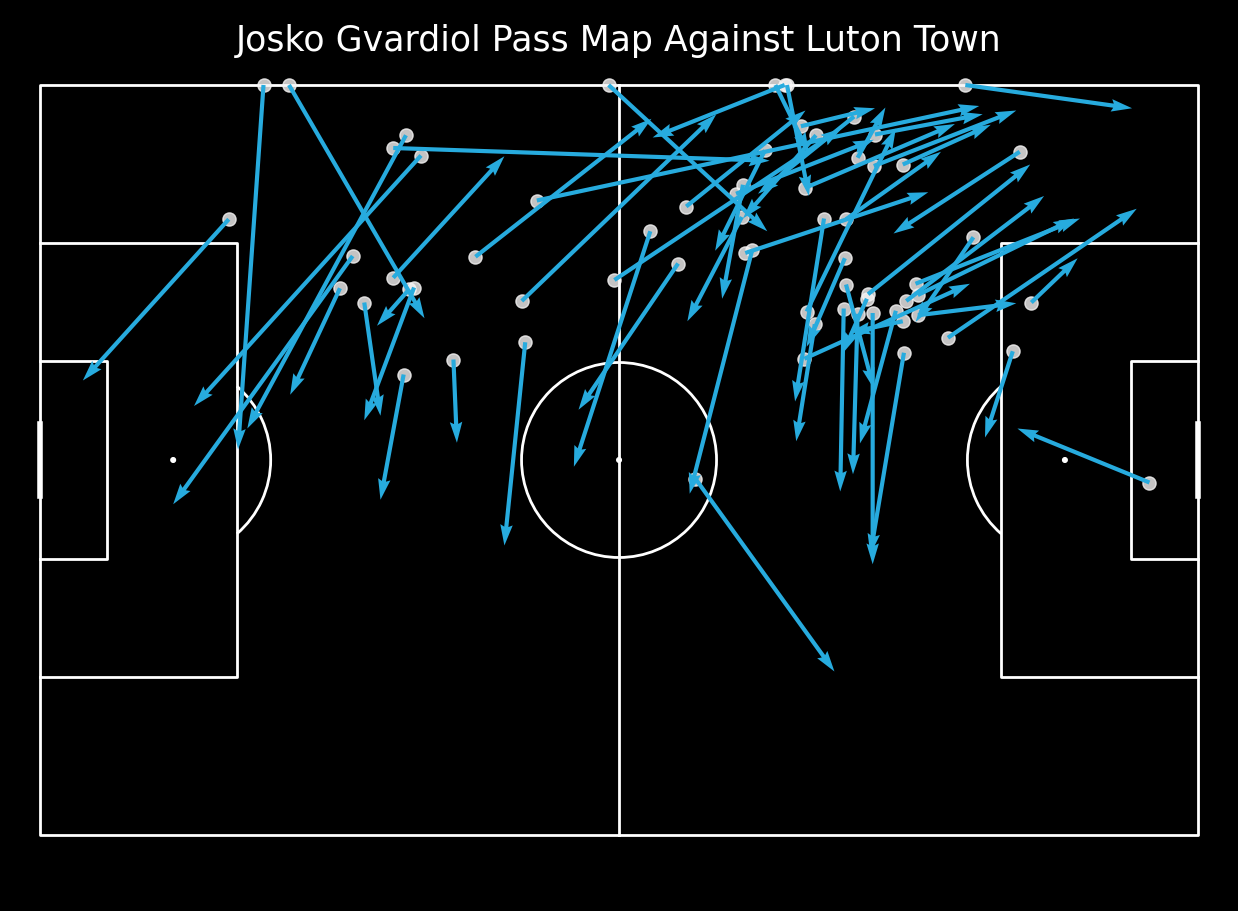

In [133]:
df_whoscored.reset_index(inplace=True)
df_whoscored.rename(columns={'index': 'id'}, inplace=True)
df_whoscored['id'] += 1

player = 'Josko Gvardiol'
df_player = df_whoscored.loc[df_whoscored['player'] == player]

selected_col = ['period', 'minute', 'second','x', 'y','end_x', 'end_y','outcome_type']
player_passes_df = df_player.loc[(df_player['type'] == 'Pass') & (df_player['outcome_type'] == 'Successful'), selected_col]

pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')

pitch.scatter(player_passes_df.x, player_passes_df.y, alpha = 0.8, s = 90, color = "#F6F5F5", ax=ax['pitch'])
pitch.arrows(player_passes_df.x, player_passes_df.y,player_passes_df.end_x, player_passes_df.end_y, color = "#27ABDE", ax=ax['pitch'],width=3)

        
fig.suptitle(f"{player} Pass Map Against Luton Town", fontsize = 25,color='white')
plt.savefig('MatchReports/CityHome/13-04-2024/JoskopassmapLuton.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Plot for Danger Passes (Passes within 15 seconds of a shot) by the Team

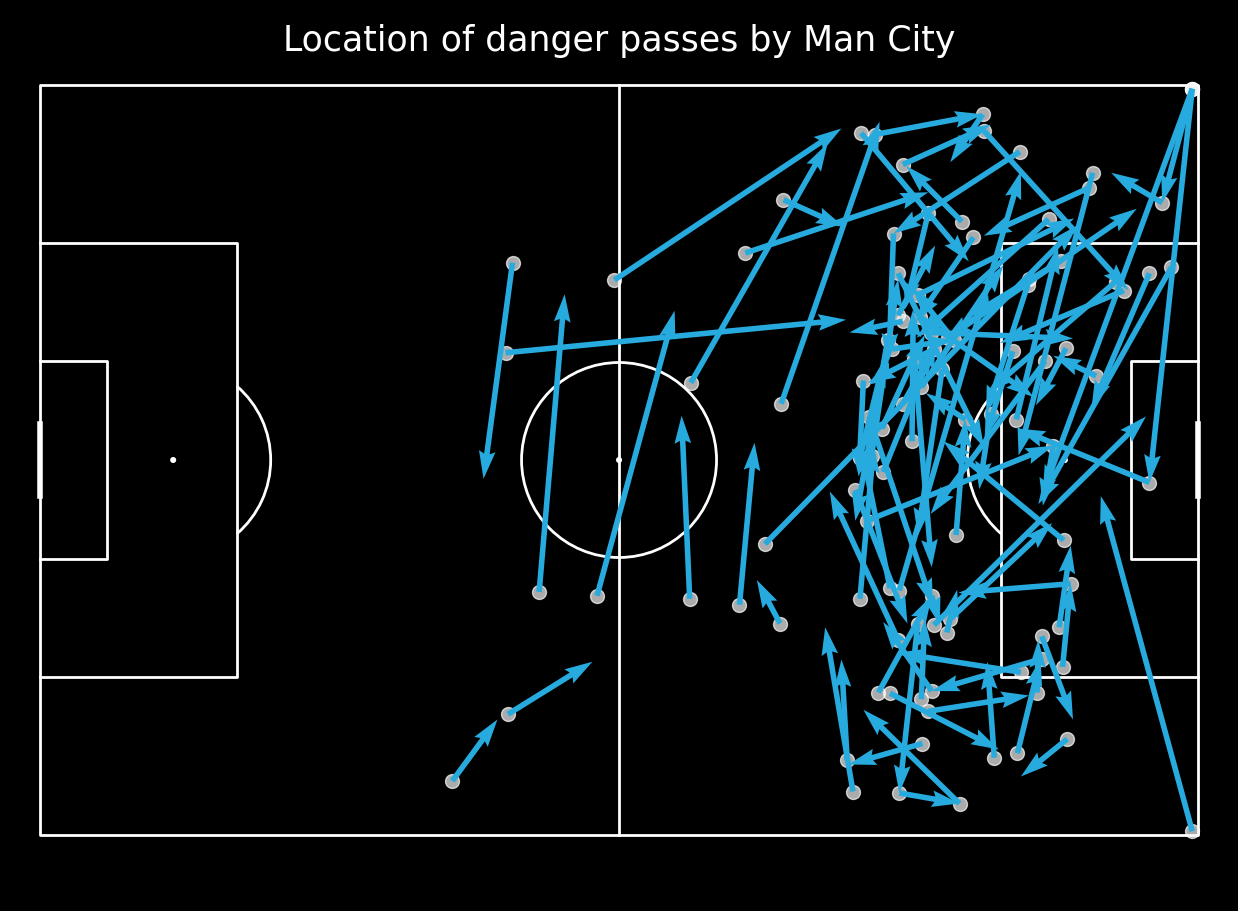

In [134]:
# Assuming the column containing the string values is named 'half'
df_whoscored['period'] = df_whoscored['period'].replace({'FirstHalf': 1, 'SecondHalf': 2})

danger_passes = pd.DataFrame()
team = 'Man City'
for period in [1, 2]:
    #keep only accurate passes by KDB that were not set pieces in this period
    mask_pass = (df_whoscored.team == team) & (df_whoscored.type == "Pass") & (df_whoscored.outcome_type == 'Successful') & (df_whoscored.period == period)
    #keep only necessary columns
    passes = df_whoscored.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second"]]
    #keep only Shots by Man City in this period
    mask_shot = (df_whoscored.team == team) & (df_whoscored.type.isin(["Goal", "MissedShots", "SavedShot"])) & (df_whoscored.period == period)
    #keep only necessary columns
    shots = df_whoscored.loc[mask_shot, ["minute", "second"]]
    #convert time to seconds
    shot_times = shots['minute']*60+shots['second']
    shot_window = 15
    #find starts of the window
    shot_start = shot_times - shot_window
    #condition to avoid negative shot starts
    shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
    #convert to seconds
    pass_times = passes['minute']*60+passes['second']
    #check if pass is in any of the windows for this half
    pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

    #keep only danger passes
    danger_passes_period = passes.loc[pass_to_shot]
    #concatenate dataframe with a previous one to keep danger passes from the whole tournament
    danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)


#plot pitch
pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='#F6F5F5', edgecolors='white', linewidth=1, alpha=0.7, ax=ax["pitch"])
#uncomment it to plot arrows
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "#27ABDE", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 25,color='white')
plt.show()

## Creating Passing Network for a Team

First Subsitutuion By Man City was made in minute : 80


C:\Users\acer\AppData\Local\Temp\ipykernel_4944\273942018.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_firsthalf['pass_recepient'] = None
C:\Users\acer\AppData\Local\Temp\ipykernel_4944\273942018.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_secondhalf['pass_recepient'] = None


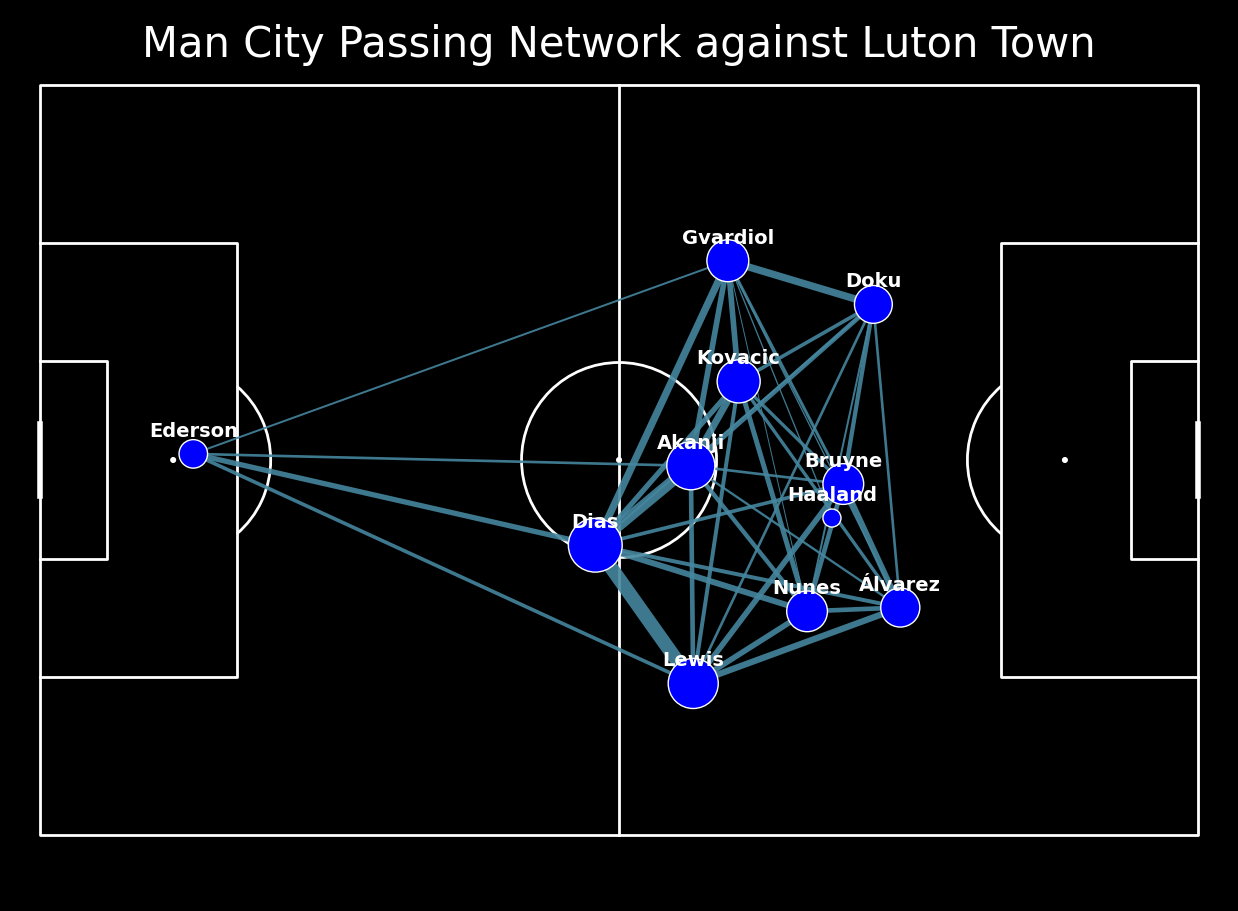

In [135]:
first_sub_min = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']=='Man City'].iloc[0]['minute']
print(f"First Subsitutuion By Man City was made in minute : {first_sub_min}")
first_sub_sec = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']=='Man City'].iloc[0]['second']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 1) & (df_whoscored.outcome_type == 'Successful')
passes_firsthalf = df_whoscored.loc[mask_passes]
passes_firsthalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_firsthalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_firsthalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_firsthalf) - 1):
        if passes_firsthalf.team.iloc[i] == passes_firsthalf.team.iloc[i+1]:
            passes_firsthalf.at[i, 'pass_recepient'] = passes_firsthalf.at[i+1, 'player']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 2) & (df_whoscored.outcome_type == 'Successful')
passes_secondhalf = df_whoscored.loc[mask_passes]
passes_secondhalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_secondhalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_secondhalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_secondhalf) - 1):
        if passes_secondhalf.team.iloc[i] == passes_secondhalf.team.iloc[i+1]:
            passes_secondhalf.at[i, 'pass_recepient'] = passes_secondhalf.at[i+1, 'player']

df_whoscored_pass = pd.concat([passes_firsthalf,passes_secondhalf], ignore_index=True)
#make df_whoscored with successfull passes by England until the first substitution
mask_city = (df_whoscored_pass.team == "Man City") & (df_whoscored_pass.minute < first_sub_min)
#taking necessary columns
df_whoscored_pass = df_whoscored_pass.loc[mask_city, ['x', 'y', 'end_x', 'end_y', "player", "pass_recepient"]]
df_whoscored_pass["player"] = df_whoscored_pass["player"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass["pass_recepient"] = df_whoscored_pass["pass_recepient"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass.reset_index(inplace=True)

df_whoscored_pass = df_whoscored_pass[df_whoscored_pass['pass_recepient'] != 'None']

scatter_df_whoscored = pd.DataFrame()
for i, name in enumerate(df_whoscored_pass["player"].unique()):
    passx = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["x"].to_numpy()
    recx = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_x"].to_numpy()
    passy = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["y"].to_numpy()
    recy = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_y"].to_numpy()
    scatter_df_whoscored.at[i, "player"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df_whoscored.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df_whoscored.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df_whoscored.at[i, "no"] = df_whoscored_pass.loc[df_whoscored_pass["player"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df_whoscored['marker_size'] = (scatter_df_whoscored['no'] / scatter_df_whoscored['no'].max() * 1500)

#counting passes between players
df_whoscored_pass["pair_key"] = df_whoscored_pass.apply(lambda x: "_".join(sorted([x["player"], x["pass_recepient"]])), axis=1)
lines_df_whoscored = df_whoscored_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df_whoscored.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df_whoscored = lines_df_whoscored[lines_df_whoscored['pass_count']>2]

#plot once again pitch and vertices
pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')
pitch.scatter(scatter_df_whoscored.x, scatter_df_whoscored.y, s=scatter_df_whoscored.marker_size, color='blue', edgecolors='white', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df_whoscored.iterrows():
    pitch.annotate(row.player, xy=(row.x, row.y+3), c='white', va='center', ha='center', weight = "bold", size=14, ax=ax["pitch"], zorder = 4)

for i, row in lines_df_whoscored.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['x'].iloc[0]
        player1_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['y'].iloc[0]
        player2_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['x'].iloc[0]
        player2_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['y'].iloc[0]
        #print(scatter_df_whoscored.index)
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df_whoscored['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=0.9, lw=line_width, zorder=2, color="#45869E", ax = ax["pitch"])

fig.suptitle("Man City Passing Network against Luton Town", fontsize = 30,color='white')
plt.savefig('MatchReports/CityHome/13-04-2024/PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Another Way of Creating a Passing Network with html file

In [136]:
import re
import json
def extract_json_from_html(html_path, save_output=False):
    #html_file = open(html_path, 'r')
    #html = html_file.read()
    #html_file.close()
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [137]:
html_path = './ManCity-Madrid.html'
json_data_txt = extract_json_from_html(html_path)

In [138]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df_whoscored = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df_whoscored["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df_whoscored = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df_whoscored["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df_whoscored = pd.concat([players_home_df_whoscored, players_away_df_whoscored])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df_whoscored, teams_dict

In [139]:
data = json.loads(json_data_txt)
events_dict, players_df_whoscored, teams_dict = extract_data_from_dict(data)

In [140]:
def get_passes_df_whoscored(events_dict):
    df_whoscored = pd.DataFrame(events_dict)
    df_whoscored['eventType'] = df_whoscored.apply(lambda row: row['type']['displayName'], axis=1)
    df_whoscored['outcomeType'] = df_whoscored.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df_whoscored["receiver"] = df_whoscored["playerId"].shift(-1)

    # filter only passes
    passes_ids = df_whoscored.index[df_whoscored['eventType'] == 'Pass']
    df_whoscored_passes = df_whoscored.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_whoscored_passes

In [141]:
passes_df_whoscored = get_passes_df_whoscored(events_dict)

In [142]:
def get_passes_between_df_whoscored(team_id, passes_df_whoscored, players_df_whoscored):
    # filter for only team
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored["teamId"] == team_id]

    # add column with first eleven players only
    passes_df_whoscored = passes_df_whoscored.merge(players_df_whoscored[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df_whoscored = (passes_df_whoscored.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df_whoscored.columns = ['x', 'y', 'count']
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.merge(players_df_whoscored[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df_whoscored = passes_df_whoscored.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df_whoscored['pos_max'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df_whoscored['pos_min'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df_whoscored = passes_player_ids_df_whoscored.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df_whoscored.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_min', right_index=True)
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df_whoscored, average_locs_and_count_df_whoscored

In [143]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(home_team_id, passes_df_whoscored, players_df_whoscored)

away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(away_team_id, passes_df_whoscored, players_df_whoscored)

In [145]:
def pass_network_visualization(ax, passes_between_df_whoscored, average_locs_and_count_df_whoscored, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df_whoscored['width'] = (passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df_whoscored['marker_size'] = (average_locs_and_count_df_whoscored['count']
                                                / average_locs_and_count_df_whoscored['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df_whoscored), 1))
    c_transparency = passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df_whoscored['x'] = pitch.dim.right - passes_between_df_whoscored['x']
        passes_between_df_whoscored['y'] = pitch.dim.right - passes_between_df_whoscored['y']
        passes_between_df_whoscored['x_end'] = pitch.dim.right - passes_between_df_whoscored['x_end']
        passes_between_df_whoscored['y_end'] = pitch.dim.right - passes_between_df_whoscored['y_end']
        average_locs_and_count_df_whoscored['x'] = pitch.dim.right - average_locs_and_count_df_whoscored['x']
        average_locs_and_count_df_whoscored['y'] = pitch.dim.right - average_locs_and_count_df_whoscored['y']

    pass_lines = pitch.lines(passes_between_df_whoscored.x, passes_between_df_whoscored.y,
                             passes_between_df_whoscored.x_end, passes_between_df_whoscored.y_end, lw=passes_between_df_whoscored.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df_whoscored.x, average_locs_and_count_df_whoscored.y,
                               s=average_locs_and_count_df_whoscored.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df_whoscored.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#C4C4C4', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

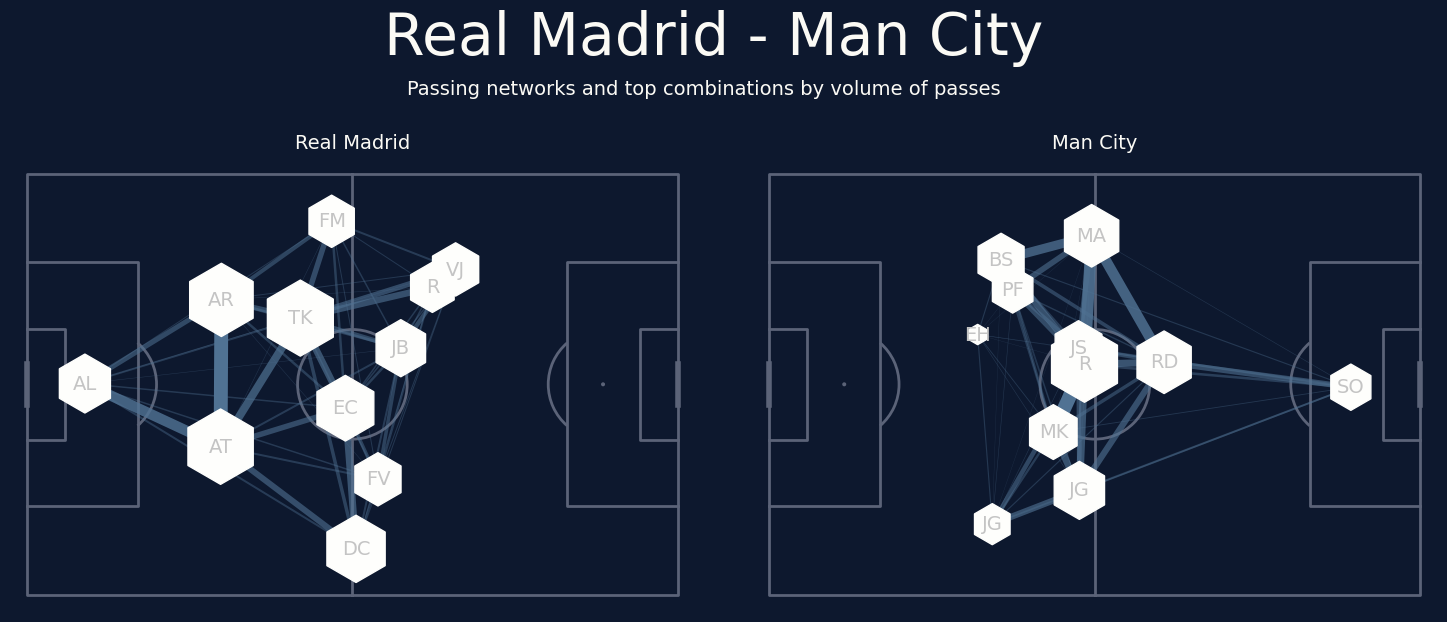

In [146]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'
#font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         #"RobotoCondensed-Medium.ttf?raw=true"))

# home team viz
pass_network_visualization(axes[0], home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
plt.savefig('output.png', bbox_inches='tight')
plt.show()